In [ ]:
!pip install gymnasium numpy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import numpy as np
import random
import os
import time
import math
import gymnasium as gym
from gymnasium import spaces
import datetime
import shutil
import pandas as pd
import csv
from numpy.core.multiarray import _reconstruct

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ========== ENVIRONMENT ==========
class MakNeebRLEnv(gym.Env):
    def __init__(self):
        super(MakNeebRLEnv, self).__init__()
        self.board_size = 8
        self.action_space = spaces.Discrete(self.board_size * self.board_size * self.board_size * self.board_size)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.board_size, self.board_size), dtype=np.int8)
        self.reset()

    def _encode_action(self, from_row, from_col, to_row, to_col):
        return from_row * (8*8*8) + from_col * (8*8) + to_row * 8 + to_col

    def _decode_action(self, action):
        from_row = action // (8*8*8)
        action %= (8*8*8)
        from_col = action // (8*8)
        action %= (8*8)
        to_row = action // 8
        to_col = action % 8
        return (from_row, from_col), (to_row, to_col)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.board = np.zeros((self.board_size, self.board_size), dtype=np.int8)
        self.board[0, :] = 1
        self.board[7, :] = -1
        self.current_player = 1
        self.turns_without_capture = 0
        self.max_turns_without_capture = 50
        return self.board.copy(), {"current_player": self.current_player}

    def get_legal_actions(self):
        legal_actions = []
        for r_from in range(self.board_size):
            for c_from in range(self.board_size):
                if self.board[r_from, c_from] == self.current_player:
                    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        for i in range(1, self.board_size):
                            r_to, c_to = r_from + dr * i, c_from + dc * i
                            if not (0 <= r_to < self.board_size and 0 <= c_to < self.board_size):
                                break
                            if self.board[r_to, c_to] != 0:
                                break
                            action = self._encode_action(r_from, c_from, r_to, c_to)
                            legal_actions.append(action)
        return legal_actions

    def step(self, action):
        legal_actions = self.get_legal_actions()
        if action not in legal_actions:
            return self.board.copy(), -10.0, True, False, {"error": "Illegal move"}

        (from_row, from_col), (to_row, to_col) = self._decode_action(action)
        self.board[to_row, to_col] = self.current_player
        self.board[from_row, from_col] = 0

        captured_count = self._check_and_capture(to_row, to_col)
        reward = captured_count * 2

        if captured_count > 0:
            self.turns_without_capture = 0
        else:
            self.turns_without_capture += 1

        done, winner = self.get_game_status()
        if done:
            if winner == self.current_player:
                reward += 20
            elif winner == -self.current_player:
                reward -= 20
            elif winner == 0:
                reward += 5

        self.current_player *= -1
        info = {"current_player": self.current_player, "captured": captured_count > 0}
        return self.board.copy(), float(reward), done, False, info

    def _check_and_capture(self, r, c):
        total_captured = 0
        opponent = -self.current_player

        for dr, dc in [(1, 0), (0, 1)]:
            line_pieces = []
            if dr == 1:
                for i in range(self.board_size):
                    if self.board[i, c] != 0:
                        line_pieces.append({'player': self.board[i, c], 'pos': (i, c)})
            else:
                for i in range(self.board_size):
                    if self.board[r, i] != 0:
                        line_pieces.append({'player': self.board[r, i], 'pos': (r, i)})

            if len(line_pieces) < 2:
                continue

            captured_in_this_line = set()

            # Direct captures (sandwich pattern)
            for i in range(len(line_pieces) - 2):
                p1, p2, p3 = line_pieces[i], line_pieces[i+1], line_pieces[i+2]
                if (p1['player'] == self.current_player and
                    p3['player'] == self.current_player and
                    p2['player'] == opponent):
                    captured_in_this_line.add(p2['pos'])

            # Multiple captures between pieces
            my_indices = [i for i, p in enumerate(line_pieces) if p['player'] == self.current_player]
            if len(my_indices) >= 2:
                for i in range(len(my_indices) - 1):
                    start_idx, end_idx = my_indices[i], my_indices[i+1]
                    if end_idx > start_idx + 1:
                        is_all_opponent = all(line_pieces[k]['player'] == opponent
                                            for k in range(start_idx + 1, end_idx))
                        if is_all_opponent:
                            for k in range(start_idx + 1, end_idx):
                                captured_in_this_line.add(line_pieces[k]['pos'])

            # Apply captures
            for pos_r, pos_c in captured_in_this_line:
                self.board[pos_r, pos_c] = 0
                total_captured += 1

        return total_captured

    def get_game_status(self):
        player1_pieces = np.sum(self.board == 1)
        player_minus_1_pieces = np.sum(self.board == -1)

        if player1_pieces == 0:
            return True, -1
        if player_minus_1_pieces == 0:
            return True, 1
        if not self.get_legal_actions_for_player(-self.current_player):
            return True, self.current_player

        if self.turns_without_capture >= self.max_turns_without_capture:
            if player1_pieces > player_minus_1_pieces:
                return True, 1
            elif player_minus_1_pieces > player1_pieces:
                return True, -1
            else:
                return True, 0

        return False, 0

    def get_legal_actions_for_player(self, player):
        for r_from in range(self.board_size):
            for c_from in range(self.board_size):
                if self.board[r_from, c_from] == player:
                    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        r_to, c_to = r_from + dr, c_from + dc
                        if (0 <= r_to < self.board_size and
                            0 <= c_to < self.board_size and
                            self.board[r_to, c_to] == 0):
                            return [1]
        return []

    def render(self, mode='human'):
        pass

    def copy(self):
        new_env = MakNeebRLEnv()
        new_env.board = self.board.copy()
        new_env.current_player = self.current_player
        new_env.turns_without_capture = self.turns_without_capture
        return new_env

In [ ]:
    # ========== NEURAL NETWORK ==========
    class ResNetBlock(nn.Module):
        def __init__(self, num_channels):
            super(ResNetBlock, self).__init__()
            self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(num_channels)
            self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(num_channels)

        def forward(self, x):
            residual = x
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += residual
            return F.relu(out)

    class MakNeebNet(nn.Module):
        def __init__(self, board_size=8, num_res_blocks=5, num_channels=64, action_size=4096):
            super(MakNeebNet, self).__init__()
            self.conv_in = nn.Conv2d(1, num_channels, kernel_size=3, padding=1)
            self.bn_in = nn.BatchNorm2d(num_channels)
            self.res_blocks = nn.ModuleList([ResNetBlock(num_channels) for _ in range(num_res_blocks)])

            # Policy head
            self.policy_conv = nn.Conv2d(num_channels, 2, kernel_size=1)
            self.policy_bn = nn.BatchNorm2d(2)
            self.policy_fc = nn.Linear(2 * board_size * board_size, action_size)

            # Value head
            self.value_conv = nn.Conv2d(num_channels, 1, kernel_size=1)
            self.value_bn = nn.BatchNorm1d(1 * board_size * board_size)
            self.value_fc1 = nn.Linear(1 * board_size * board_size, 256)
            self.value_fc2 = nn.Linear(256, 1)

        def forward(self, x):
            x = x.unsqueeze(1)
            x = F.relu(self.bn_in(self.conv_in(x)))

            for block in self.res_blocks:
                x = block(x)

            # Policy head
            policy = F.relu(self.policy_bn(self.policy_conv(x)))
            policy = policy.view(policy.size(0), -1)
            policy = self.policy_fc(policy)

            # Value head
            value = F.relu(self.value_conv(x))
            value = value.view(value.size(0), -1)
            value = self.value_bn(value)
            value = F.relu(self.value_fc1(value))
            value = torch.tanh(self.value_fc2(value))

            return F.log_softmax(policy, dim=1), value

In [5]:
# ========== MCTS ==========
class MCTSNode:
    def __init__(self, parent=None, prior_p=1.0):
        self.parent = parent
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.prior_p = prior_p

    def expand(self, action_priors):
        for action, prior in action_priors:
            if action not in self.children:
                self.children[action] = MCTSNode(parent=self, prior_p=prior)

    def select(self, c_puct):
        best_score = -float('inf')
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = self.get_ucb_score(child, c_puct)
            if score > best_score:
                best_score, best_action, best_child = score, action, child

        return best_action, best_child

    def get_ucb_score(self, child, c_puct):
        q_value = child.value()
        u_value = c_puct * child.prior_p * math.sqrt(self.visit_count) / (1 + child.visit_count)
        return q_value + u_value

    def value(self):
        return self.value_sum / self.visit_count if self.visit_count > 0 else 0

    def backpropagate(self, value):
        self.visit_count += 1
        self.value_sum += value
        if self.parent:
            self.parent.backpropagate(-value)

class MCTS:
    def __init__(self, model, device, c_puct=1.5, num_simulations=100):
        self.model = model
        self.device = device
        self.c_puct = c_puct
        self.num_simulations = num_simulations

    @torch.no_grad()
    def search(self, env):
        root = MCTSNode()

        # Get initial policy and value
        initial_board_tensor = torch.tensor(
            env.board * env.current_player,
            dtype=torch.float32
        ).unsqueeze(0).to(self.device)

        log_policy, value = self.model(initial_board_tensor)
        policy = torch.exp(log_policy).squeeze(0).cpu().numpy()

        legal_actions = env.get_legal_actions()
        if not legal_actions:
            return np.ones(env.action_space.n) / env.action_space.n, value.item()

        action_priors = [(action, policy[action]) for action in legal_actions]
        root.expand(action_priors)

        # Run simulations
        for _ in range(self.num_simulations):
            node = root
            sim_env = env.copy()

            # Selection
            while node.children:
                action, node = node.select(self.c_puct)
                sim_env.step(action)

            # Evaluation
            done, winner = sim_env.get_game_status()
            value = 0

            if not done:
                # Expansion and evaluation
                board_tensor = torch.tensor(
                    sim_env.board * sim_env.current_player,
                    dtype=torch.float32
                ).unsqueeze(0).to(self.device)

                log_policy, value_tensor = self.model(board_tensor)
                policy = torch.exp(log_policy).squeeze(0).cpu().numpy()
                value = value_tensor.item()

                legal_actions = sim_env.get_legal_actions()
                if legal_actions:
                    action_priors = [(action, policy[action]) for action in legal_actions]
                    node.expand(action_priors)
            else:
                # Terminal node
                if winner != 0:
                    value = 1 if winner == sim_env.current_player else -1

            # Backpropagation
            node.backpropagate(-value)

        # Return visit count distribution and root value
        visit_counts = np.array([
            root.children.get(a, MCTSNode()).visit_count
            for a in range(env.action_space.n)
        ])

        if visit_counts.sum() == 0:
            return np.ones(env.action_space.n) / env.action_space.n, root.value()

        action_probs = visit_counts / visit_counts.sum()
        return action_probs, root.value()

In [6]:
def calculate_training_metrics(model, batch_data, device):
    """Calculate additional training metrics"""
    boards, target_policies, target_values = batch_data

    with torch.no_grad():
        log_policies, predicted_values = model(boards)
        policies = torch.exp(log_policies)

        # Entropy
        entropy = -(policies * log_policies).sum(dim=1).mean()

        # KL Divergence
        kl_div = torch.sum(target_policies * torch.log(target_policies / (policies + 1e-8)), dim=1).mean()

        # Value prediction bias
        value_bias = (predicted_values.squeeze() - target_values).mean()

        # Learning rate (from optimizer)
        current_lr = None

    return {
        'entropy': entropy.item(),
        'approx_kl': kl_div.item(),
        'value_bias': value_bias.item(),
        'current_lr': current_lr
    }

In [7]:
# ========== SELF-PLAY WORKER (CPU-only) ==========
def self_play_worker(model_weights, mcts_simulations, c_puct):
    """CPU-only self-play worker"""
    device = torch.device("cpu")

    # Create model and load weights
    model = MakNeebNet(action_size=4096).to(device)
    model.load_state_dict(model_weights)
    model.eval()

    # Create environment and MCTS
    env = MakNeebRLEnv()
    mcts = MCTS(model, device, c_puct, mcts_simulations)

    # Play one game
    game_history = []
    move_history = []  # เพิ่ม: เก็บประวัติการเดิน
    current_player = 1
    player_moves = {1: 0, -1: 0}  # เพิ่ม: นับจำนวนการเดินของแต่ละฝั่ง
    player_times = {1: 0.0, -1: 0.0}  # เพิ่ม: เวลาที่ใช้ของแต่ละฝั่ง

    while True:
        move_start_time = time.time()

        # Get board from current player's perspective
        board = env.board * env.current_player

        # Get action probabilities and value from MCTS
        action_probs, mcts_value = mcts.search(env)

        # Store training data
        game_history.append((board.copy(), action_probs.copy(), current_player))

        # Sample action and make move
        action = np.random.choice(len(action_probs), p=action_probs)

        # เพิ่ม: บันทึกการเดิน
        (from_row, from_col), (to_row, to_col) = env._decode_action(action)
        move_history.append({
            'player': current_player,
            'from_pos': (from_row, from_col),
            'to_pos': (to_row, to_col),
            'action': action
        })

        _, _, done, _, _ = env.step(action)

        # เพิ่ม: อัพเดทจำนวนการเดินและเวลา
        move_time = time.time() - move_start_time
        player_moves[current_player] += 1
        player_times[current_player] += move_time

        current_player *= -1

        if done:
            break

    # Assign final rewards
    _, winner = env.get_game_status()

    # เพิ่ม: คำนวณหมากที่เหลือ
    final_pieces = {
        1: np.sum(env.board == 1),
        -1: np.sum(env.board == -1)
    }

    training_examples = []
    for board, action_probs, player in game_history:
        if winner == 0:
            reward = 0.0
        else:
            reward = 1.0 if winner == player else -1.0
        training_examples.append((board, action_probs, reward))

    # เพิ่ม: ส่งข้อมูลเกมกลับด้วย
    game_data = {
        'winner': winner,
        'total_moves': len(move_history),
        'player_1_moves': player_moves[1],
        'player_minus1_moves': player_moves[-1],
        'player_1_time': player_times[1],
        'player_minus1_time': player_times[-1],
        'final_pieces_p1': final_pieces[1],
        'final_pieces_p_1': final_pieces[-1],
        'move_history': move_history
    }

    return training_examples, game_data

In [8]:
# ========== TRAINING FUNCTIONS ==========
def save_checkpoint(iteration, model, optimizer, replay_buffer, checkpoint_path):
    # Save normally
    torch.save({
        'iteration': iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'replay_buffer': list(replay_buffer)
    }, checkpoint_path)

    # Auto-backup every 5 iterations
    if iteration % 5 == 0:
        try:
            from google.colab import drive
            drive.mount('/content/drive', force_remount=False)

            backup_dir = "/content/drive/MyDrive/AlphaZero_Backups"
            os.makedirs(backup_dir, exist_ok=True)

            # Timestamped backup
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            backup_path = f"{backup_dir}/checkpoint_iter_{iteration}_{timestamp}.pth"
            shutil.copy2(checkpoint_path, backup_path)

            # Latest backup
            latest_path = f"{backup_dir}/checkpoint_latest.pth"
            shutil.copy2(checkpoint_path, latest_path)

            print(f"✅ Backed up checkpoint to Google Drive: {backup_path}")
        except Exception as e:
            print(f"⚠️  Google Drive checkpoint backup failed: {e}")


def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Load training checkpoint"""
    if not os.path.exists(checkpoint_path):
        print("No checkpoint found, starting from scratch")
        return 0, deque(maxlen=50000)

    # Load checkpoint with weights_only=False to allow loading non-tensor objects
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    replay_buffer = deque(checkpoint['replay_buffer'], maxlen=50000)

    print(f"Loaded checkpoint from iteration {checkpoint['iteration']}")
    return checkpoint['iteration'] + 1, replay_buffer


def train_model(model, replay_buffer, optimizer, device, batch_size=128, num_epochs=10):
    """Train the model on replay buffer data"""
    model.train()

    buffer_list = list(replay_buffer)

    for epoch in range(num_epochs):
        random.shuffle(buffer_list)
        total_loss = 0
        policy_loss_sum = 0
        value_loss_sum = 0
        entropy_sum = 0
        kl_sum = 0
        value_acc_sum = 0
        num_batches = 0

        for i in range(0, len(buffer_list) - batch_size + 1, batch_size):
            batch = buffer_list[i:i + batch_size]

            boards, target_policies, target_values = zip(*batch)

            # Convert to tensors
            boards = torch.tensor(np.array(boards), dtype=torch.float32).to(device)
            target_policies = torch.tensor(np.array(target_policies), dtype=torch.float32).to(device)
            target_values = torch.tensor(target_values, dtype=torch.float32).unsqueeze(1).to(device)

            # Forward pass
            optimizer.zero_grad()
            log_policies, predicted_values = model(boards)

            # Calculate losses
            policy_loss = -(target_policies * log_policies).sum(dim=1).mean()
            value_loss = F.mse_loss(predicted_values, target_values)
            total_loss_batch = policy_loss + value_loss

            # Calculate metrics
            policy = torch.exp(log_policies)
            entropy = -(policy * log_policies).sum(dim=1).mean()
            kl = (target_policies * (torch.log(target_policies + 1e-10) - log_policies)).sum(dim=1).mean()
            value_acc = (predicted_values.round() == target_values.round()).float().mean()

            # Backward pass
            total_loss_batch.backward()
            optimizer.step()

            total_loss += total_loss_batch.item()
            policy_loss_sum += policy_loss.item()
            value_loss_sum += value_loss.item()
            entropy_sum += entropy.item()
            kl_sum += kl.item()
            value_acc_sum += value_acc.item()
            num_batches += 1

        if num_batches > 0:
            avg_loss = total_loss / num_batches
            avg_policy_loss = policy_loss_sum / num_batches
            avg_value_loss = value_loss_sum / num_batches
            avg_entropy = entropy_sum / num_batches
            avg_kl = kl_sum / num_batches
            avg_value_acc = value_acc_sum / num_batches
            print(f"  Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Policy Loss: {avg_policy_loss:.4f}, Value Loss: {avg_value_loss:.4f}, Entropy: {avg_entropy:.4f}, KL: {avg_kl:.6f}, Value Acc: {avg_value_acc:.4f}")

In [9]:
def calculate_iteration_stats(game_data_list):
    """คำนวณสถิติจากข้อมูลเกมในรอบนั้น"""
    if not game_data_list:
        return {
            'win_rate_player1': 0.0,
            'win_rate_player_minus1': 0.0,
            'draw_rate': 0.0,
            'avg_game_length': 0.0,
            'avg_final_pieces_p1': 0.0,
            'avg_final_pieces_p_1': 0.0
        }

    total_games = len(game_data_list)

    # นับผลการแข่งขัน
    player1_wins = sum(1 for game in game_data_list if game['winner'] == 1)
    player_minus1_wins = sum(1 for game in game_data_list if game['winner'] == -1)
    draws = sum(1 for game in game_data_list if game['winner'] == 0)

    # คำนวณอัตราชนะ
    win_rate_player1 = player1_wins / total_games
    win_rate_player_minus1 = player_minus1_wins / total_games
    draw_rate = draws / total_games

    # คำนวณค่าเฉลี่ย
    avg_game_length = sum(game['total_moves'] for game in game_data_list) / total_games
    avg_final_pieces_p1 = sum(game['final_pieces_p1'] for game in game_data_list) / total_games
    avg_final_pieces_p_1 = sum(game['final_pieces_p_1'] for game in game_data_list) / total_games

    return {
        'win_rate_player1': round(win_rate_player1, 4),
        'win_rate_player_minus1': round(win_rate_player_minus1, 4),
        'draw_rate': round(draw_rate, 4),
        'avg_game_length': round(avg_game_length, 2),
        'avg_final_pieces_p1': round(avg_final_pieces_p1, 2),
        'avg_final_pieces_p_1': round(avg_final_pieces_p_1, 2)
    }

In [10]:
def save_game_data_to_csv(game_data_list, iteration, filename_prefix="game_data"):
    """บันทึกข้อมูลเกมลงไฟล์ CSV"""

    # ข้อมูลสรุปเกม
    game_summary = []
    # ประวัติการเดินทั้งหมด
    all_moves = []

    for game_idx, game_data in enumerate(game_data_list):
        # สรุปเกม
        game_summary.append({
            'iteration': iteration,
            'game_number': game_idx + 1,
            'winner': game_data['winner'],
            'total_moves': game_data['total_moves'],
            'player_1_moves': game_data['player_1_moves'],
            'player_minus1_moves': game_data['player_minus1_moves'],
            'player_1_time_seconds': round(game_data['player_1_time'], 3),
            'player_minus1_time_seconds': round(game_data['player_minus1_time'], 3),
            'final_pieces_p1': game_data['final_pieces_p1'],
            'final_pieces_p_1': game_data['final_pieces_p_1']
        })

        # ประวัติการเดิน
        for move_idx, move in enumerate(game_data['move_history']):
            all_moves.append({
                'iteration': iteration,
                'game_number': game_idx + 1,
                'move_number': move_idx + 1,
                'player': move['player'],
                'from_row': move['from_pos'][0],
                'from_col': move['from_pos'][1],
                'to_row': move['to_pos'][0],
                'to_col': move['to_pos'][1],
                'action_id': move['action']
            })

    # บันทึกไฟล์
    pd.DataFrame(game_summary).to_csv(f"{filename_prefix}_summary_iter_{iteration}.csv", index=False)
    pd.DataFrame(all_moves).to_csv(f"{filename_prefix}_moves_iter_{iteration}.csv", index=False)

    return game_summary, all_moves

In [13]:
# ========== MAIN TRAINING LOOP ==========
def main():
    # Hyperparameters
    NUM_GAMES_PER_ITERATION = 20  # Reduced for faster testing
    NUM_TRAIN_EPOCHS = 5
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    REPLAY_BUFFER_SIZE = 10000
    MCTS_SIMULATIONS = 25  # Reduced for faster testing
    C_PUCT = 1.5
    CHECKPOINT_PATH = "/content/drive/MyDrive/AlphaZero_Backups/checkpoint_latest.pth"
    SAVE_INTERVAL = 5 # Save every 5 iterations

    # Setup device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    model = MakNeebNet(action_size=4096).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Load checkpoint if exists
    start_iteration, replay_buffer = load_checkpoint(model, optimizer, CHECKPOINT_PATH, device)

    # Training statistics log
    training_log = []

    # เพิ่ม: ตัวแปรเก็บข้อมูลสะสมทุกรอบ
    accumulated_game_summary = []
    accumulated_game_moves = []
    accumulated_iteration_stats = []

    try:
        for iteration in range(start_iteration, 50):  # Changed the end of the range to 50
            iteration_start_time = time.time() # Define iteration_start_time here
            print(f"\n--- Iteration {iteration} ---")

            # Self-play phase
            print(f"Generating {NUM_GAMES_PER_ITERATION} self-play games...")

            # Get model weights for workers (ensure CPU compatibility)
            model_weights = {k: v.cpu() for k, v in model.state_dict().items()}

            # Generate self-play games sequentially (removed Ray)
            game_results = []
            game_data_list = []  # เพิ่ม: เก็บข้อมูลเกม

            for game_num in range(NUM_GAMES_PER_ITERATION):
                game_start = time.time()
                training_examples, game_data = self_play_worker(model_weights, MCTS_SIMULATIONS, C_PUCT)

                replay_buffer.extend(training_examples)
                game_data_list.append(game_data)

                game_time = time.time() - game_start
                print(f"  Game {game_num + 1}: Time={game_time:.1f}s, Examples={len(training_examples)}, Winner={game_data['winner']}")

            print(f"Replay buffer size: {len(replay_buffer)}")

            # เพิ่ม: คำนวณสถิติรอบนี้
            iteration_stats = calculate_iteration_stats(game_data_list)

            # Training phase
            iteration_log = {
                'iteration': iteration,
                'win_rate_player1': iteration_stats['win_rate_player1'],
                'win_rate_player_minus1': iteration_stats['win_rate_player_minus1'],
                'draw_rate': iteration_stats['draw_rate'],
                'avg_game_length': iteration_stats['avg_game_length'],
                'avg_final_pieces_p1': iteration_stats['avg_final_pieces_p1'],
                'avg_final_pieces_p_1': iteration_stats['avg_final_pieces_p_1'],
                'new_training_examples': len(game_data_list) * len(training_examples) if training_examples else 0,
                'replay_buffer_size': len(replay_buffer),
                'iteration_time': 0.0
            }

            # เพิ่ม: เก็บสถิติรอบนี้
            accumulated_iteration_stats.append(iteration_log)

            # Log iteration results
            training_log.append(iteration_log)

            # เพิ่ม: เก็บข้อมูลเกมรอบนี้เข้าไปในข้อมูลสะสม
            for game_idx, game_data in enumerate(game_data_list):
                accumulated_game_summary.append({
                    'iteration': iteration,
                    'game_number': game_idx + 1,
                    'winner': game_data['winner'],
                    'total_moves': game_data['total_moves'],
                    'player_1_moves': game_data['player_1_moves'],
                    'player_minus1_moves': game_data['player_minus1_moves'],
                    'player_1_time_seconds': round(game_data['player_1_time'], 3),
                    'player_minus1_time_seconds': round(game_data['player_minus1_time'], 3),
                    'final_pieces_p1': game_data['final_pieces_p1'],
                    'final_pieces_p_1': game_data['final_pieces_p_1']
                })

                for move_idx, move in enumerate(game_data['move_history']):
                    accumulated_game_moves.append({
                        'iteration': iteration,
                        'game_number': game_idx + 1,
                        'move_number': move_idx + 1,
                        'player': move['player'],
                        'from_row': move['from_pos'][0],
                        'from_col': move['from_pos'][1],
                        'to_row': move['to_pos'][0],
                        'to_col': move['to_pos'][1],
                        'action_id': move['action']
                    })

            # Training phase
            training_losses = []

            if len(replay_buffer) >= BATCH_SIZE:
                print("Training model...")
                training_start = time.time()
                training_losses = train_model(model, replay_buffer, optimizer, device, BATCH_SIZE, NUM_TRAIN_EPOCHS)
                training_time = time.time() - training_start
                print(f"Training completed in {training_time:.1f}s")

                if training_losses:
                    # Calculate average metrics from training epochs
                    avg_metrics = {
                        'avg_policy_loss': np.mean([e['policy_loss'] for e in training_losses]),
                        'avg_value_loss': np.mean([e['value_loss'] for e in training_losses]),
                        'avg_entropy': np.mean([e['entropy'] for e in training_losses]),
                        'avg_approx_kl': np.mean([e['approx_kl'] for e in training_losses]),
                        'avg_value_acc': np.mean([e['value_acc'] for e in training_losses]),
                    }
                    iteration_log.update(avg_metrics)

                    # Display summary
                    print(f"📊 TRAINING METRICS SUMMARY:")
                    print(f"Avg Policy Loss: {avg_metrics['avg_policy_loss']:.4f}")
                    print(f"Avg Value Loss: {avg_metrics['avg_value_loss']:.4f}")
                    print(f"Avg Entropy: {avg_metrics['avg_entropy']:.4f}")
                    print(f"Avg KL Divergence: {avg_metrics['avg_approx_kl']:.6f}")
                    print(f"Avg Value Accuracy: {avg_metrics['avg_value_acc']:.4f}")

            # Calculate iteration statistics (including time)
            iteration_end_time = time.time()
            iteration_log['iteration_time'] = iteration_end_time - iteration_start_time

            # Print summary (using data from iteration_log)
            print(f"\n📊 ITERATION {iteration} SUMMARY:")
            print(f"Buffer size: {iteration_log['replay_buffer_size']}")
            if 'avg_policy_loss' in iteration_log: # Check if training happened
                print(f"Avg Policy Loss: {iteration_log['avg_policy_loss']:.4f}, Avg Value Loss: {iteration_log['avg_value_loss']:.4f}")
                print(f"Avg Entropy: {iteration_log['avg_entropy']:.4f}, Avg KL Divergence: {iteration_log['avg_approx_kl']:.6f}, Avg Value Accuracy: {iteration_log['avg_value_acc']:.4f}")
            print(f"Time: {iteration_log['iteration_time']:.1f}s")

            # Save checkpoint and logs every SAVE_INTERVAL iterations OR at iteration 49 (special case)
            if iteration % SAVE_INTERVAL == 0 or iteration == 49:
                save_checkpoint(iteration, model, optimizer, replay_buffer, CHECKPOINT_PATH)

                # บันทึกข้อมูลสะสม
                if iteration == 49:
                    # กรณีพิเศษ: iteration 49 (บันทึกข้อมูล iteration 46-49)
                    range_start = 46
                    range_end = 49
                else:
                    # กรณีปกติ: บันทึกตาม SAVE_INTERVAL
                    range_start = iteration - SAVE_INTERVAL + 1
                    range_end = iteration

                # 1. บันทึกข้อมูลเกม
                summary_filename = f"game_data_summary_rounds_{range_start}_to_{range_end}.csv"
                moves_filename = f"game_data_moves_rounds_{range_start}_to_{range_end}.csv"
                stats_filename = f"iteration_stats_rounds_{range_start}_to_{range_end}.csv"

                pd.DataFrame(accumulated_game_summary).to_csv(summary_filename, index=False)
                pd.DataFrame(accumulated_game_moves).to_csv(moves_filename, index=False)
                pd.DataFrame(accumulated_iteration_stats).to_csv(stats_filename, index=False)

                print(f"📁 Saved game data: {len(accumulated_game_summary)} games, {len(accumulated_game_moves)} moves")
                print(f"📁 Saved iteration stats: {len(accumulated_iteration_stats)} iterations")

                try:
                    from google.colab import drive
                    drive.mount('/content/drive', force_remount=False)

                    backup_dir = "/content/drive/MyDrive/AlphaZero_Backups"
                    os.makedirs(backup_dir, exist_ok=True)

                    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

                    # Backup files
                    files_to_backup = [
                        (summary_filename, f"game_summary_rounds_{range_start}_to_{range_end}_{timestamp}.csv"),
                        (moves_filename, f"game_moves_rounds_{range_start}_to_{range_end}_{timestamp}.csv"),
                        (stats_filename, f"iteration_stats_rounds_{range_start}_to_{range_end}_{timestamp}.csv")
                    ]

                    for local_file, backup_name in files_to_backup:
                        if os.path.exists(local_file):
                            backup_path = f"{backup_dir}/{backup_name}"
                            shutil.copy2(local_file, backup_path)
                            print(f"✅ Backed up: {backup_path}")

                    # Save training log
                    df_log = pd.DataFrame(training_log)
                    log_backup_path = f"{backup_dir}/training_log_iter_{iteration}_{timestamp}.csv"
                    df_log.to_csv(log_backup_path, index=False)
                    print(f"✅ Backed up training log to Google Drive: {log_backup_path}")

                    # Backup additional game files if they exist
                    game_summary_file = f"game_data_summary_iter_{iteration}.csv"
                    game_moves_file = f"game_data_moves_iter_{iteration}.csv"

                    if os.path.exists(game_summary_file):
                        shutil.copy2(game_summary_file, f"{backup_dir}/game_summary_iter_{iteration}_{timestamp}.csv")
                    if os.path.exists(game_moves_file):
                        shutil.copy2(game_moves_file, f"{backup_dir}/game_moves_iter_{iteration}_{timestamp}.csv")

                except Exception as e:
                    print(f"⚠️  Google Drive log backup failed: {e}")

                # Clear accumulated data after saving
                accumulated_game_summary = []
                accumulated_game_moves = []
                accumulated_iteration_stats = []

            # GPU memory management
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("Training interrupted by user")
    finally:
        print("\nTraining completed")

        # Save final training log
        if training_log:
            df_log = pd.DataFrame(training_log)
            df_log.to_csv("final_training_log.csv", index=False)
            print("📁 Final training log saved to final_training_log.csv")

In [14]:
if __name__ == "__main__":
    main()

Training on cpu
Loaded checkpoint from iteration 45

--- Iteration 46 ---
Generating 20 self-play games...
  Game 1: Time=9.1s, Examples=89, Winner=0
  Game 2: Time=23.7s, Examples=220, Winner=-1
  Game 3: Time=13.8s, Examples=59, Winner=1
  Game 4: Time=19.2s, Examples=183, Winner=1
  Game 5: Time=6.7s, Examples=54, Winner=-1
  Game 6: Time=28.6s, Examples=264, Winner=-1
  Game 7: Time=26.7s, Examples=245, Winner=1
  Game 8: Time=16.5s, Examples=151, Winner=1
  Game 9: Time=5.0s, Examples=50, Winner=0
  Game 10: Time=20.9s, Examples=178, Winner=-1
  Game 11: Time=4.9s, Examples=50, Winner=0
  Game 12: Time=7.4s, Examples=58, Winner=-1
  Game 13: Time=5.9s, Examples=57, Winner=1
  Game 14: Time=15.3s, Examples=140, Winner=-1
  Game 15: Time=39.0s, Examples=353, Winner=1
  Game 16: Time=7.5s, Examples=64, Winner=0
  Game 17: Time=11.9s, Examples=113, Winner=1
  Game 18: Time=11.4s, Examples=111, Winner=1
  Game 19: Time=18.7s, Examples=163, Winner=1
  Game 20: Time=4.7s, Examples=50, Wi

In [ ]:
# โหลดโมเดล
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MakNeebNet(action_size=4096).to(device)
checkpoint_path = "/content/drive/MyDrive/AlphaZero_Backups/checkpoint_latest.pth" # ตรวจสอบพาธให้ถูกต้อง

try:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully from checkpoint.")
    model.eval() # ตั้งค่าโมเดลเป็นโหมด evaluation
except FileNotFoundError:
    print("Checkpoint file not found. Cannot load model.")
    # จัดการกรณีที่ไม่พบไฟล์ checkpoint
    exit()

# สร้าง MCTS agent
mcts_agent = MCTS(model, device, c_puct=1.5, num_simulations=400) # ใช้ simulations เยอะขึ้นเพื่อการเล่นจริง

# สร้างสภาพแวดล้อมเกม
env = MakNeebRLEnv()
observation, info = env.reset()

# เริ่มเล่นเกม
print("Game Start!")
print(env.board) # แสดงกระดานเริ่มต้น

done = False
while not done:
    current_player = env.current_player
    print(f"\nPlayer {current_player}'s turn")

    # ให้ MCTS Agent เลือกการเดิน
    # ในการเล่นจริง อาจจะใช้ temperature = 0 เพื่อเลือกการเดินที่มี visit count สูงสุด
    # แทนที่จะสุ่มตาม distribution เหมือนตอน self-play
    action_probs, value = mcts_agent.search(env)

    # เลือกการเดินที่มี probability สูงสุด
    best_action = np.argmax(action_probs)
    (from_row, from_col), (to_row, to_col) = env._decode_action(best_action)

    print(f"Agent chooses move: ({from_row}, {from_col}) -> ({to_row}, {to_col}) (Action ID: {best_action})")

    # ทำการเดินในสภาพแวดล้อม
    observation, reward, done, truncated, info = env.step(best_action)

    # แสดงกระดานปัจจุบัน
    print(env.board)
    print(f"Reward: {reward}, Done: {done}")

    if done:
        _, winner = env.get_game_status()
        if winner == 0:
            print("Game ended in a draw!")
        else:
            print(f"Player {winner} wins!")
        break

# คุณสามารถเพิ่มโค้ดเพื่อเล่นกับผู้เล่นคนอื่น หรือเล่นโมเดลกับตัวเองได้ที่นี่

Model loaded successfully from checkpoint.
Game Start!
[[ 1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]]

Player 1's turn
Agent chooses move: (0, 6) -> (2, 6) (Action ID: 406)
[[ 1  1  1  1  1  1  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]]
Reward: 0.0, Done: False

Player -1's turn
Agent chooses move: (7, 0) -> (3, 0) (Action ID: 3608)
[[ 1  1  1  1  1  1  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1 -1 -1 -1 -1 -1 -1]]
Reward: 0.0, Done: False

Player 1's turn
Agent chooses move: (0, 5) -> (4, 5) (Action ID: 357)
[[ 1  1  1  1  1  0  0  1]
 [

   iteration  game_number  winner  total_moves  player_1_moves  \
0          0            1      -1           73              37   
1          0            2       0          287             144   
2          0            3      -1          170              85   
3          0            4      -1          156              78   
4          0            5      -1          136              68   

   player_minus1_moves  player_1_time_seconds  player_minus1_time_seconds  \
0                   36                  4.356                       4.205   
1                  143                 15.114                      14.728   
2                   85                  8.962                       8.720   
3                   78                  8.707                       7.958   
4                   68                  7.073                       6.822   

   final_pieces_p1  final_pieces_p_1  
0                6                 7  
1                3                 3  
2                0     

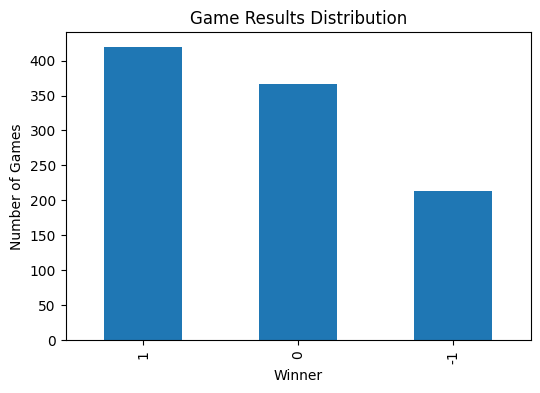

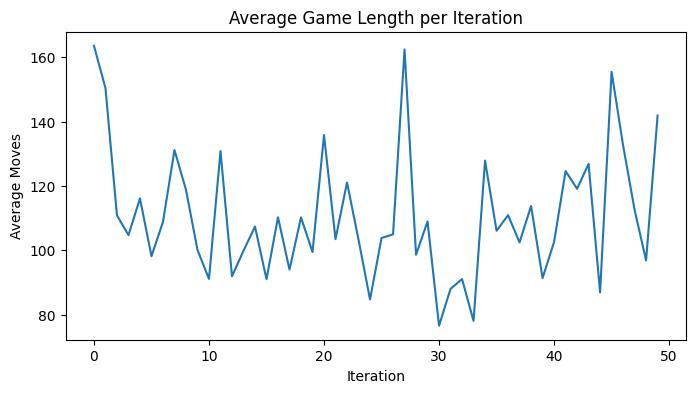

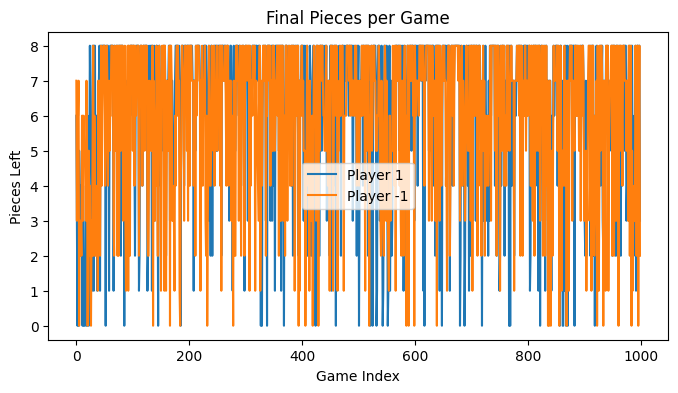

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# โหลดข้อมูลเกม summary
game_summary_df = pd.read_csv("dataset/game_summary_rounds.csv")

# แสดงข้อมูลเบื้องต้น
print(game_summary_df.head())
print(game_summary_df.describe())

# สถิติผลการแข่งขัน
win_counts = game_summary_df['winner'].value_counts()
plt.figure(figsize=(6,4))
win_counts.plot(kind='bar')
plt.title('Game Results Distribution')
plt.xlabel('Winner')
plt.ylabel('Number of Games')
plt.show()

# ความยาวเกมเฉลี่ยแต่ละรอบ
if 'iteration' in game_summary_df.columns:
    avg_game_length_by_iter = game_summary_df.groupby('iteration')['total_moves'].mean()
    plt.figure(figsize=(8,4))
    avg_game_length_by_iter.plot()
    plt.title('Average Game Length per Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Average Moves')
    plt.show()

# จำนวนหมากที่เหลือของแต่ละฝั่ง
plt.figure(figsize=(8,4))
plt.plot(game_summary_df['final_pieces_p1'], label='Player 1')
plt.plot(game_summary_df['final_pieces_p_1'], label='Player -1')
plt.title('Final Pieces per Game')
plt.xlabel('Game Index')
plt.ylabel('Pieces Left')
plt.legend()
plt.show()

   iteration  win_rate_player1  win_rate_player_minus1  draw_rate  \
0          0              0.25                    0.65       0.10   
1          1              0.65                    0.30       0.05   
2          2              0.50                    0.20       0.30   
3          3              0.45                    0.10       0.45   
4          4              0.35                    0.25       0.40   

   avg_game_length  avg_final_pieces_p1  avg_final_pieces_p_1  \
0           163.55                 2.10                  4.50   
1           150.40                 4.75                  3.30   
2           110.85                 6.55                  6.00   
3           104.70                 7.00                  5.90   
4           116.10                 6.25                  5.75   

   new_training_examples  replay_buffer_size  iteration_time  
0                   2520                3271      341.373700  
1                   2280                6279      320.099360  
2    

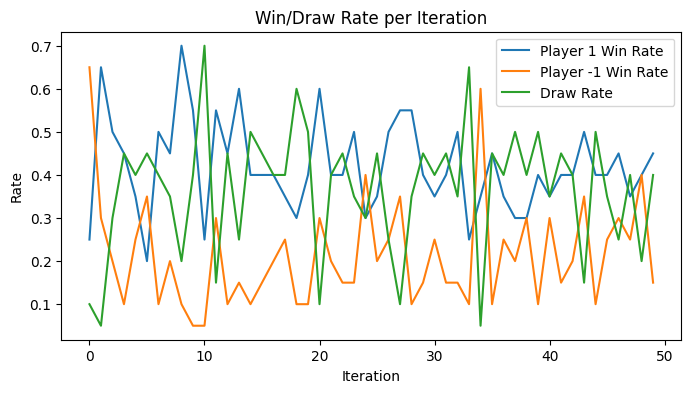

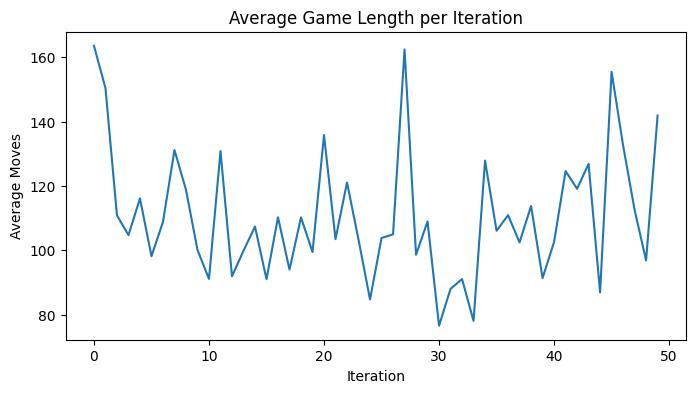

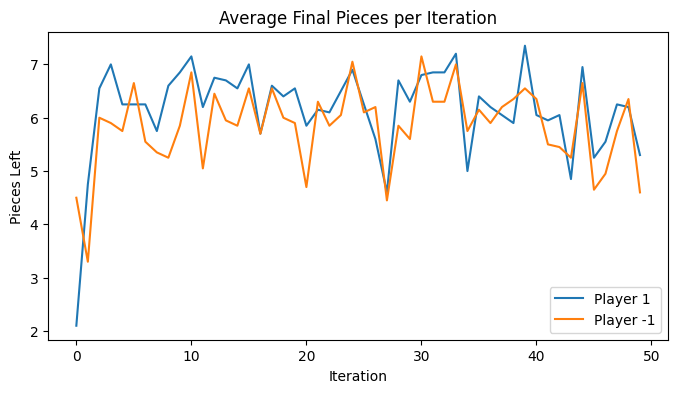

In [7]:
import pandas as pd

import matplotlib.pyplot as plt

# โหลดไฟล์ iteration_stats_rounds.csv
iteration_stats_df = pd.read_csv("dataset/iteration_stats_rounds.csv")

# แสดงข้อมูลเบื้องต้น
print(iteration_stats_df.head())
print(iteration_stats_df.describe())

# EDA: อัตราชนะของแต่ละฝั่ง
plt.figure(figsize=(8,4))
plt.plot(iteration_stats_df['iteration'], iteration_stats_df['win_rate_player1'], label='Player 1 Win Rate')
plt.plot(iteration_stats_df['iteration'], iteration_stats_df['win_rate_player_minus1'], label='Player -1 Win Rate')
plt.plot(iteration_stats_df['iteration'], iteration_stats_df['draw_rate'], label='Draw Rate')
plt.title('Win/Draw Rate per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.legend()
plt.show()

# EDA: ความยาวเกมเฉลี่ยแต่ละรอบ
plt.figure(figsize=(8,4))
plt.plot(iteration_stats_df['iteration'], iteration_stats_df['avg_game_length'])
plt.title('Average Game Length per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Average Moves')
plt.show()

# EDA: จำนวนหมากที่เหลือเฉลี่ยของแต่ละฝั่ง
plt.figure(figsize=(8,4))
plt.plot(iteration_stats_df['iteration'], iteration_stats_df['avg_final_pieces_p1'], label='Player 1')
plt.plot(iteration_stats_df['iteration'], iteration_stats_df['avg_final_pieces_p_1'], label='Player -1')
plt.title('Average Final Pieces per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Pieces Left')
plt.legend()
plt.show()